In [8]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
old_X, old_y = mnist.data, mnist.target

In [12]:
import torch
import numpy as np

mask = (old_y == '0') | (old_y == '1')
X, y = old_X[mask], old_y[mask].astype(np.int64)

split = int(len(X) * 6 / 7)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_X = torch.from_numpy(X[:split]).float().to(device)
train_y = torch.from_numpy(y[:split]).float().T.view(-1, 1).to(device)
test_X = torch.from_numpy(X[split:]).float().to(device)
test_y = torch.from_numpy(y[split:]).float().T.view(-1, 1).to(device)

train_X /= 255
test_X /= 255

train_X.shape, train_y.shape, test_X.shape, test_y.shape

(torch.Size([12668, 784]),
 torch.Size([12668, 1]),
 torch.Size([2112, 784]),
 torch.Size([2112, 1]))

In [13]:
import torch.nn as nn, torch.nn.functional as F

class BinClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(len(train_X[0]), 1, requires_grad=True, device=device))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, device=device))
    
    def forward(self, X):
        return X @ self.weight + self.bias

In [31]:
model = BinClassifier()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_errors, valid_errors = [], []
epoch = 3000

for i in range(epoch):
    model.train()
    optimizer.zero_grad()
    logits = model(train_X)
    loss = criterion(logits, train_y)
    train_errors.append(loss.item())

    model.eval()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        val_loss = criterion(model(test_X), test_y)
    valid_errors.append(val_loss.item())
    
    if i % 1000 == 0:
        print(loss.item(), val_loss.item())

4.618598461151123 4.188767433166504
0.004751340951770544 0.00487887766212225
0.0014389895368367434 0.003960388246923685


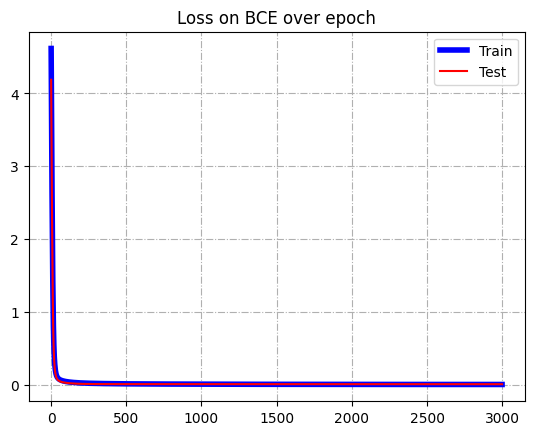

In [33]:
import matplotlib.pyplot as plt

x_axis = torch.linspace(0, 3000 - 1, 3000)
plt.plot(x_axis, train_errors, color='blue', linewidth=4, label='Train')
plt.plot(x_axis, valid_errors, color='red', label='Test')
plt.title('Loss on BCE over epoch')
plt.grid(linestyle='-.')
plt.legend()
plt.show()

In [34]:
torch.save(model.state_dict(), '../inference/param/MNIST_bin_classifier.pth')